# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 500
# scheduler_patience_mapping = {"CIFAR10": 200, "CIFAR100": 200, "ImageNet2012": 30}

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 80
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if valid_data is not None:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
else:
    valid_dataloader = None

if test_data is not None:
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("test.transforms =", test_data.transform, test_dataloader.batch_size)
else:
    test_dataloader = None

train.transforms = Compose(
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
test.transforms = ToTensor() 128


## Confirm that the dataset is loaded properly

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
mean of X tensor([0.4786, 0.4786, 0.4569])
Shape of y: torch.Size([128]) torch.int64


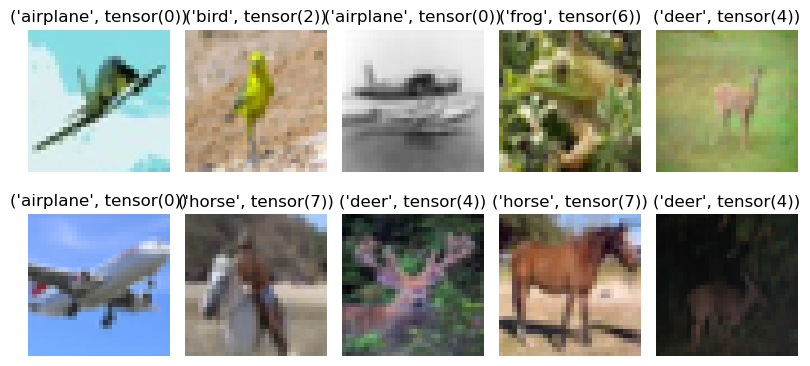

In [6]:
if test_data is not None:
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis("off")
            count += 1

            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [9]:
# model.named_modules

In [10]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [11]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [12]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [13]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_path=file_path)

## (4) Define Learning Rate schedualer

In [14]:
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode="min",
#     patience=scheduler_patience_mapping[DATASET],
#     factor=0.1,
#     verbose=True,
#     threshold=1e-4,
#     cooldown=100,
# )

scheduler = MultiStepLR(optimizer, milestones=[82, 40], gamma=0.1)
#
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 81]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 91]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 40]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 45]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 81]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 91]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 40]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n====================================================

## (5) Define AMP scaler

In [15]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [17]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [18]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/500] :


100%|██████████| 391/391 [00:10<00:00, 38.03it/s]


Train Loss: 0.0058 | Train Acc: 20.00%
Test  Loss: 2.3044 | Test Acc: 10.00%
updated best eval loss : 2.304447741448125
--------------------------------------------------
[Epoch 2/500] :


100%|██████████| 391/391 [00:06<00:00, 58.65it/s]


Train Loss: 0.0047 | Train Acc: 33.75%
Test  Loss: 1.8019 | Test Acc: 31.82%
updated best eval loss : 1.8019460998003995
--------------------------------------------------
[Epoch 3/500] :


100%|██████████| 391/391 [00:05<00:00, 69.93it/s]


Train Loss: 0.0040 | Train Acc: 47.50%
Test  Loss: 1.5239 | Test Acc: 44.59%
updated best eval loss : 1.523924703839459
--------------------------------------------------
[Epoch 4/500] :


100%|██████████| 391/391 [00:05<00:00, 67.00it/s]


Train Loss: 0.0034 | Train Acc: 56.25%
Test  Loss: 1.1826 | Test Acc: 58.48%
updated best eval loss : 1.1825908588457712
--------------------------------------------------
[Epoch 5/500] :


100%|██████████| 391/391 [00:05<00:00, 69.75it/s]


Train Loss: 0.0032 | Train Acc: 56.25%
Test  Loss: 0.9723 | Test Acc: 65.14%
updated best eval loss : 0.9723416385771353
--------------------------------------------------
[Epoch 6/500] :


100%|██████████| 391/391 [00:05<00:00, 69.44it/s]


Train Loss: 0.0034 | Train Acc: 50.00%
Test  Loss: 0.9400 | Test Acc: 68.01%
updated best eval loss : 0.940004526814328
--------------------------------------------------
[Epoch 7/500] :


100%|██████████| 391/391 [00:06<00:00, 64.39it/s]


Train Loss: 0.0022 | Train Acc: 71.25%
Test  Loss: 0.9078 | Test Acc: 68.19%
updated best eval loss : 0.9078259641611124
--------------------------------------------------
[Epoch 8/500] :


100%|██████████| 391/391 [00:08<00:00, 47.96it/s]


Train Loss: 0.0023 | Train Acc: 63.75%
Test  Loss: 0.8090 | Test Acc: 72.12%
updated best eval loss : 0.8090079087245313
--------------------------------------------------
[Epoch 9/500] :


100%|██████████| 391/391 [00:08<00:00, 44.42it/s]


Train Loss: 0.0024 | Train Acc: 70.00%
Test  Loss: 0.9064 | Test Acc: 68.48%
--------------------------------------------------
[Epoch 10/500] :


100%|██████████| 391/391 [00:08<00:00, 45.20it/s]


Train Loss: 0.0023 | Train Acc: 65.00%
Test  Loss: 0.7308 | Test Acc: 75.07%
updated best eval loss : 0.7308068064194692
--------------------------------------------------
[Epoch 11/500] :


100%|██████████| 391/391 [00:08<00:00, 47.25it/s]


Train Loss: 0.0026 | Train Acc: 65.00%
Test  Loss: 0.7464 | Test Acc: 75.64%
--------------------------------------------------
[Epoch 12/500] :


100%|██████████| 391/391 [00:08<00:00, 45.13it/s]


Train Loss: 0.0021 | Train Acc: 67.50%
Test  Loss: 0.6786 | Test Acc: 76.47%
updated best eval loss : 0.6785562962670869
--------------------------------------------------
[Epoch 13/500] :


100%|██████████| 391/391 [00:08<00:00, 45.75it/s]


Train Loss: 0.0019 | Train Acc: 81.25%
Test  Loss: 0.6333 | Test Acc: 77.82%
updated best eval loss : 0.6332579602169085
--------------------------------------------------
[Epoch 14/500] :


100%|██████████| 391/391 [00:08<00:00, 43.94it/s]


Train Loss: 0.0021 | Train Acc: 70.00%
Test  Loss: 0.6849 | Test Acc: 77.20%
--------------------------------------------------
[Epoch 15/500] :


100%|██████████| 391/391 [00:08<00:00, 44.66it/s]


Train Loss: 0.0023 | Train Acc: 71.25%
Test  Loss: 0.6902 | Test Acc: 76.75%
--------------------------------------------------
[Epoch 16/500] :


100%|██████████| 391/391 [00:08<00:00, 45.67it/s]


Train Loss: 0.0021 | Train Acc: 73.75%
Test  Loss: 0.5636 | Test Acc: 81.09%
updated best eval loss : 0.56359610150132
--------------------------------------------------
[Epoch 17/500] :


100%|██████████| 391/391 [00:08<00:00, 47.47it/s]


Train Loss: 0.0017 | Train Acc: 72.50%
Test  Loss: 0.6125 | Test Acc: 79.07%
--------------------------------------------------
[Epoch 18/500] :


100%|██████████| 391/391 [00:08<00:00, 46.29it/s]


Train Loss: 0.0025 | Train Acc: 63.75%
Test  Loss: 0.5283 | Test Acc: 81.70%
updated best eval loss : 0.5283236586594884
--------------------------------------------------
[Epoch 19/500] :


100%|██████████| 391/391 [00:08<00:00, 45.55it/s]


Train Loss: 0.0019 | Train Acc: 77.50%
Test  Loss: 0.5222 | Test Acc: 82.48%
updated best eval loss : 0.5222130942193768
--------------------------------------------------
[Epoch 20/500] :


100%|██████████| 391/391 [00:08<00:00, 46.77it/s]


Train Loss: 0.0020 | Train Acc: 75.00%
Test  Loss: 0.6136 | Test Acc: 78.88%
--------------------------------------------------
[Epoch 21/500] :


100%|██████████| 391/391 [00:09<00:00, 42.13it/s]


Train Loss: 0.0018 | Train Acc: 73.75%
Test  Loss: 0.5300 | Test Acc: 81.66%
--------------------------------------------------
[Epoch 22/500] :


100%|██████████| 391/391 [00:08<00:00, 44.01it/s]


Train Loss: 0.0016 | Train Acc: 80.00%
Test  Loss: 0.6032 | Test Acc: 79.54%
--------------------------------------------------
[Epoch 23/500] :


100%|██████████| 391/391 [00:09<00:00, 41.05it/s]


Train Loss: 0.0020 | Train Acc: 70.00%
Test  Loss: 0.4972 | Test Acc: 83.08%
updated best eval loss : 0.49717304638669463
--------------------------------------------------
[Epoch 24/500] :


100%|██████████| 391/391 [00:09<00:00, 42.18it/s]


Train Loss: 0.0017 | Train Acc: 72.50%
Test  Loss: 0.5623 | Test Acc: 81.68%
--------------------------------------------------
[Epoch 25/500] :


100%|██████████| 391/391 [00:08<00:00, 45.49it/s]


Train Loss: 0.0024 | Train Acc: 66.25%
Test  Loss: 0.5550 | Test Acc: 81.13%
--------------------------------------------------
[Epoch 26/500] :


100%|██████████| 391/391 [00:08<00:00, 43.71it/s]


Train Loss: 0.0016 | Train Acc: 78.75%
Test  Loss: 0.6184 | Test Acc: 78.19%
--------------------------------------------------
[Epoch 27/500] :


100%|██████████| 391/391 [00:08<00:00, 47.53it/s]


Train Loss: 0.0020 | Train Acc: 73.75%
Test  Loss: 0.5212 | Test Acc: 82.60%
--------------------------------------------------
[Epoch 28/500] :


100%|██████████| 391/391 [00:08<00:00, 44.04it/s]


Train Loss: 0.0020 | Train Acc: 72.50%
Test  Loss: 0.5055 | Test Acc: 82.50%
--------------------------------------------------
[Epoch 29/500] :


100%|██████████| 391/391 [00:09<00:00, 41.82it/s]


Train Loss: 0.0019 | Train Acc: 75.00%
Test  Loss: 0.4975 | Test Acc: 82.66%
--------------------------------------------------
[Epoch 30/500] :


100%|██████████| 391/391 [00:08<00:00, 45.68it/s]


Train Loss: 0.0018 | Train Acc: 78.75%
Test  Loss: 0.4766 | Test Acc: 83.50%
updated best eval loss : 0.4765568356725234
--------------------------------------------------
[Epoch 31/500] :


100%|██████████| 391/391 [00:09<00:00, 43.38it/s]


Train Loss: 0.0024 | Train Acc: 72.50%
Test  Loss: 0.4621 | Test Acc: 84.47%
updated best eval loss : 0.46210023345826545
--------------------------------------------------
[Epoch 32/500] :


100%|██████████| 391/391 [00:09<00:00, 42.15it/s]


Train Loss: 0.0016 | Train Acc: 78.75%
Test  Loss: 0.5697 | Test Acc: 80.68%
--------------------------------------------------
[Epoch 33/500] :


100%|██████████| 391/391 [00:09<00:00, 42.46it/s]


Train Loss: 0.0016 | Train Acc: 80.00%
Test  Loss: 0.5378 | Test Acc: 82.12%
--------------------------------------------------
[Epoch 34/500] :


100%|██████████| 391/391 [00:08<00:00, 44.04it/s]


Train Loss: 0.0015 | Train Acc: 78.75%
Test  Loss: 0.4626 | Test Acc: 84.12%
--------------------------------------------------
[Epoch 35/500] :


100%|██████████| 391/391 [00:08<00:00, 43.61it/s]


Train Loss: 0.0010 | Train Acc: 88.75%
Test  Loss: 0.4552 | Test Acc: 84.42%
updated best eval loss : 0.45521525642539884
--------------------------------------------------
[Epoch 36/500] :


100%|██████████| 391/391 [00:09<00:00, 42.56it/s]


Train Loss: 0.0016 | Train Acc: 72.50%
Test  Loss: 0.4992 | Test Acc: 82.71%
--------------------------------------------------
[Epoch 37/500] :


100%|██████████| 391/391 [00:09<00:00, 43.14it/s]


Train Loss: 0.0011 | Train Acc: 87.50%
Test  Loss: 0.5118 | Test Acc: 82.83%
--------------------------------------------------
[Epoch 38/500] :


100%|██████████| 391/391 [00:08<00:00, 45.78it/s]


Train Loss: 0.0019 | Train Acc: 73.75%
Test  Loss: 0.5239 | Test Acc: 82.14%
--------------------------------------------------
[Epoch 39/500] :


100%|██████████| 391/391 [00:08<00:00, 47.59it/s]


Train Loss: 0.0019 | Train Acc: 75.00%
Test  Loss: 0.5139 | Test Acc: 83.15%
--------------------------------------------------
[Epoch 40/500] :


100%|██████████| 391/391 [00:08<00:00, 45.10it/s]


Train Loss: 0.0016 | Train Acc: 77.50%
Test  Loss: 0.5527 | Test Acc: 82.06%
Learning Rate has changed : Now is 0.010000000000000002
--------------------------------------------------
[Epoch 41/500] :


100%|██████████| 391/391 [00:08<00:00, 46.66it/s]


Train Loss: 0.0010 | Train Acc: 90.00%
Test  Loss: 0.3281 | Test Acc: 88.83%
updated best eval loss : 0.3281272604495664
--------------------------------------------------
[Epoch 42/500] :


100%|██████████| 391/391 [00:08<00:00, 45.76it/s]


Train Loss: 0.0006 | Train Acc: 91.25%
Test  Loss: 0.3171 | Test Acc: 89.21%
updated best eval loss : 0.31706250034555605
--------------------------------------------------
[Epoch 43/500] :


100%|██████████| 391/391 [00:08<00:00, 44.74it/s]


Train Loss: 0.0009 | Train Acc: 90.00%
Test  Loss: 0.3123 | Test Acc: 89.42%
updated best eval loss : 0.3122817462758173
--------------------------------------------------
[Epoch 44/500] :


100%|██████████| 391/391 [00:09<00:00, 41.88it/s]


Train Loss: 0.0013 | Train Acc: 81.25%
Test  Loss: 0.3063 | Test Acc: 89.61%
updated best eval loss : 0.306260207974458
--------------------------------------------------
[Epoch 45/500] :


100%|██████████| 391/391 [00:08<00:00, 45.61it/s]


Train Loss: 0.0012 | Train Acc: 88.75%
Test  Loss: 0.3065 | Test Acc: 89.60%
--------------------------------------------------
[Epoch 46/500] :


  0%|          | 1/391 [00:00<00:41,  9.29it/s]

In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))

In [ ]:
earlystopper.early_stop_counter

In [ ]:
scheduler.__class__